## Решающие деревья, случайные леса и градиентный бустинг

### О задании

Задание состоит из трёх разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.  
3. В третьем разделе вы попробуете градиентный бустинг на практической задаче.

Прежде чем приступать к работе, рекомендую прочитать теорию.  
Построение решающего дерева осуществляется согласно базовому жадному алгоритму, описанному в [лекции 8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения производиться по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Построение случайного леса описано в лекции [8](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture08-ensembles.pdf), про градиентный бустинг [9](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture09-ensembles.pdf), про стекинг и блендинг в лекции  [10](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

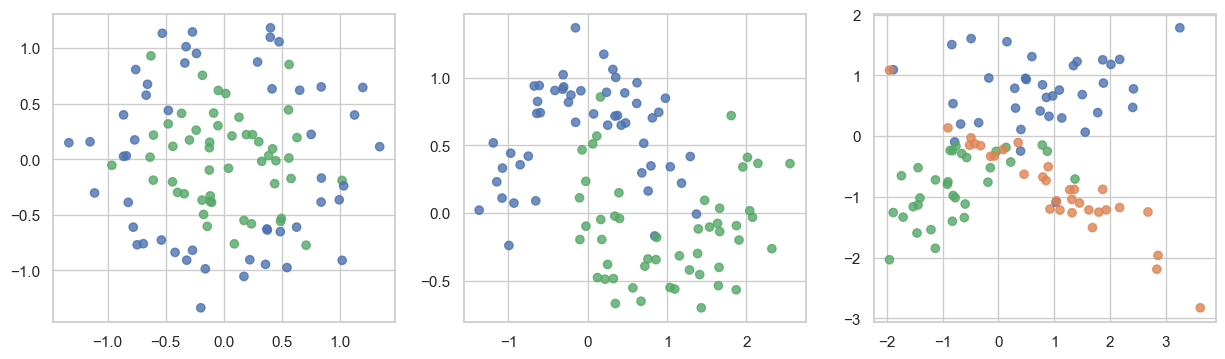

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__1.1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [6]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

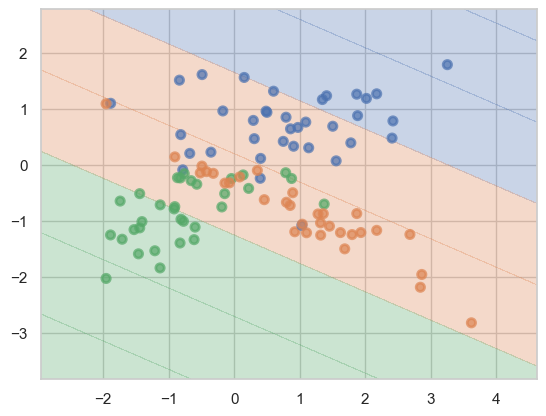

In [7]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

Датасет: Круги
Обучение:1.0000
Тест: 0.7333
Разница: 0.2667
Глубина: 6
------------------------------
Датасет: Луны
Обучение:1.0000
Тест: 0.8667
Разница: 0.1333
Глубина: 4
------------------------------
Датасет: Классы
Обучение:1.0000
Тест: 0.8333
Разница: 0.1667
Глубина: 7
------------------------------


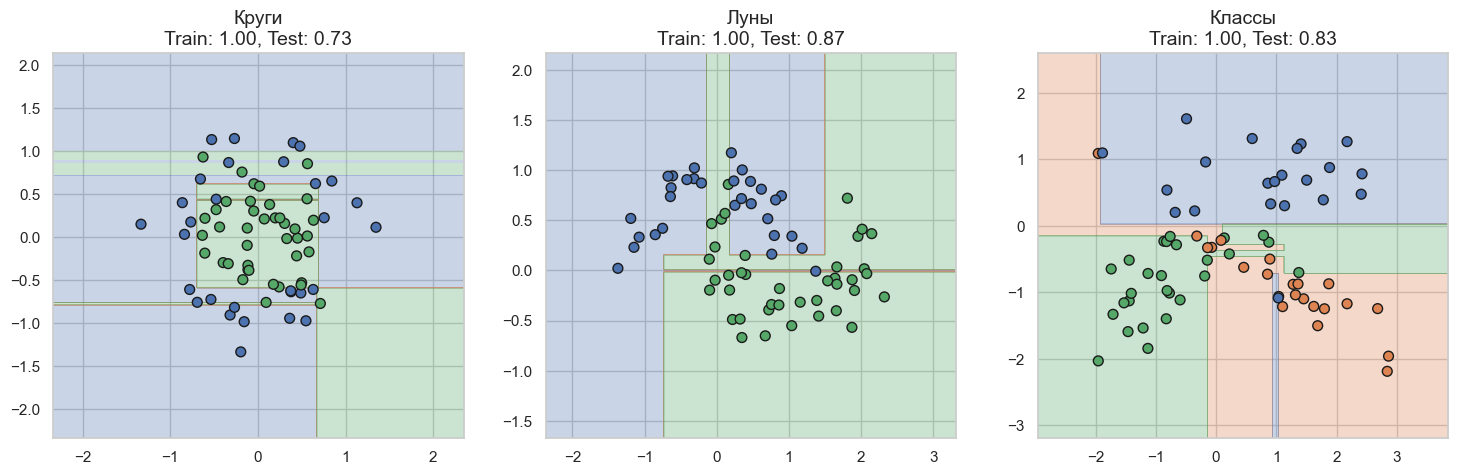

In [35]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def plot_surface(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    cmap = ListedColormap(sns.color_palette(n_colors=3))
    plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, edgecolors='k', s=50)
    plt.title(title, fontsize=14)
    
data_circles = make_circles(noise=0.2, factor=0.5, random_state=42)
data_moons = make_moons(noise=0.2, random_state=42)
data_class = make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, 
                                 class_sep=0.8, random_state=3, n_redundant=0)

datasets = [
    ("Круги", data_circles),
    ("Луны", data_moons),
    ("Классы", data_class)
]


plt.figure(figsize=(18, 5))

for i, (name, (X, y)) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)

    acc_train = tree.score(X_train, y_train)
    acc_test = tree.score(X_test, y_test)
    diff = acc_train - acc_test
    depth = tree.get_depth()
    
    print(f"Датасет: {name}")
    print(f"Обучение:{acc_train:.4f}")
    print(f"Тест: {acc_test:.4f}")
    print(f"Разница: {diff:.4f}")
    print(f"Глубина: {depth}")
    print("-" * 30)

    plt.subplot(1, 3, i + 1)
    plot_surface(tree, X_train, y_train, f"{name}\nTrain: {acc_train:.2f}, Test: {acc_test:.2f}")

plt.show()

__Ответ:__
Accuracy почти всегда равна 1.0. Разделающие поверхности рваные. Деревья без ограничения глубины сильно переобучаются. Они идеально запоминают шум в обучающих данных, но на тестовых данных ошибаются чаще

__1.2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

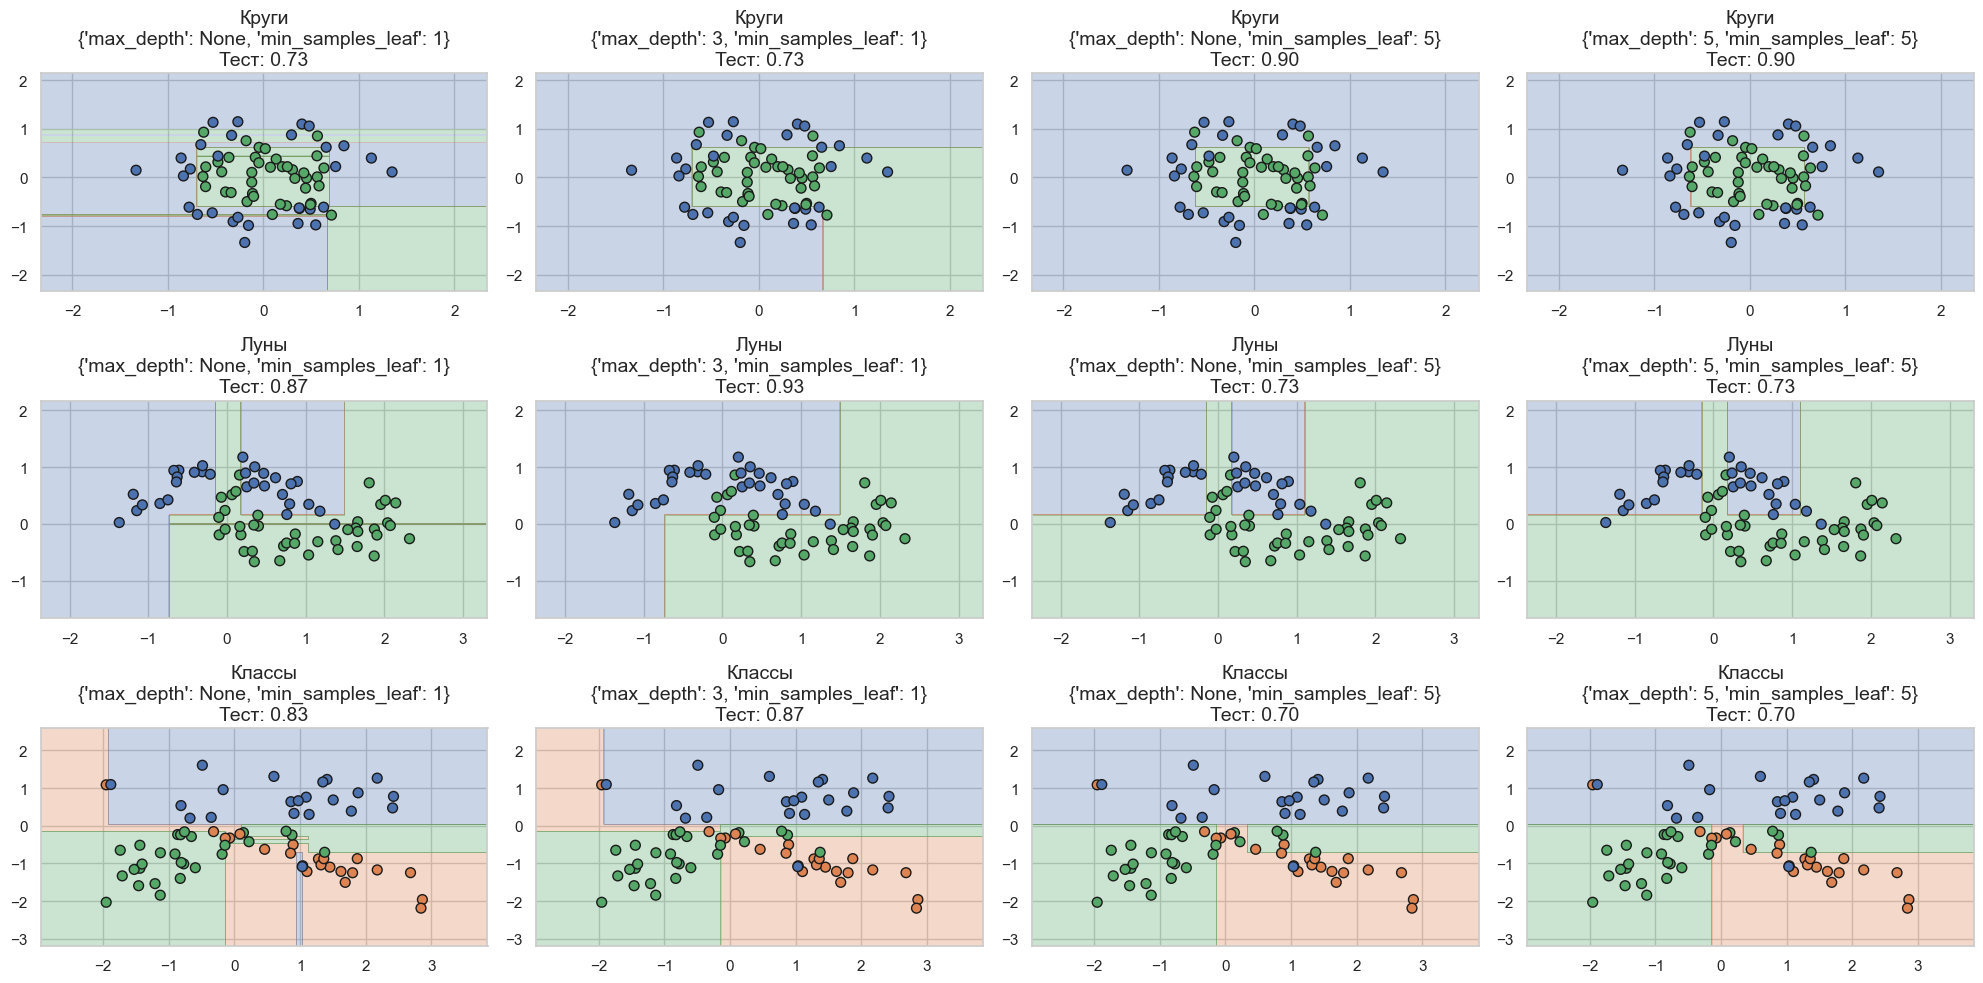

,Датасет,Обучение,Тест,Разница
0,Круги,1.000000,0.733333,0.266667
1,Круги,0.885714,0.733333,0.152381
2,Круги,0.871429,0.900000,-0.028571
3,Круги,0.871429,0.900000,-0.028571
4,Луны,1.000000,0.866667,0.133333
5,Луны,0.914286,0.933333,-0.019048
6,Луны,0.957143,0.733333,0.223810
7,Луны,0.957143,0.733333,0.223810
8,Классы,1.000000,0.833333,0.166667
9,Классы,0.942857,0.866667,0.076190


In [38]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
params_list = [
    {'max_depth': None, 'min_samples_leaf': 1},
    {'max_depth': 3,    'min_samples_leaf': 1},
    {'max_depth': None, 'min_samples_leaf': 5},
    {'max_depth': 5,    'min_samples_leaf': 5}
]

results = []

plt.figure(figsize=(20, 10))
plot_idx = 1

for name, (X, y) in datasets:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for params in params_list:
        tree = DecisionTreeClassifier(random_state=42, **params)
        tree.fit(X_train, y_train)
        
        acc_train = tree.score(X_train, y_train)
        acc_test = tree.score(X_test, y_test)
        
        # Сохраняем в таблицу
        results.append({
            "Датасет": name,
            "Обучение": acc_train,
            "Тест": acc_test,
            "Разница": acc_train - acc_test
        })
        
        plt.subplot(3, 4, plot_idx)
        plot_title = f"{name}\n{params}\nТест: {acc_test:.2f}"
        plot_surface(tree, X_train, y_train, plot_title)
        plot_idx += 1

plt.tight_layout()
plt.show()

df_res = pd.DataFrame(results)
display(df_res)

__Ответ:__
Ограничение глубины: Границы становятся более простыми и прямыми. Ошибка на трейне растет, но на тесте может улучшиться

Ограничение листа: Сглаживает границы. Мелкие островки одного класса внутри другого исчезают, так как для их выделения потребовался бы лист с 1-2 объектами

Итог: Регуляризация снижает переобучение , делая модель более устойчивой к шуму. Разделяющая поверхность становится более гладкой

# 2. Решающие деревья на 5 датасетах

__2.1. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [50]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
path = 'datasets/mushroom/agaricus-lepiota.data'
df_mush = pd.read_csv(path, header=None)

le = LabelEncoder()
for col in df_mush.columns:
    df_mush[col] = le.fit_transform(df_mush[col])

X = df_mush.iloc[:, 1:]
y = df_mush.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

train_acc = tree.score(X_train, y_train)
test_acc = tree.score(X_test, y_test)
diff = train_acc - test_acc
depth = tree.get_depth()
leaves = tree.get_n_leaves()

print(f'Точность на обучении: {train_acc:.4f}')
print(f'Точность на тесте: {test_acc:.4f}')
print(f'Разница: {diff:.4f}')
print(f'Глубина дерева: {depth}')
print(f'Количество листьев: {leaves}')

Точность на обучении: 1.0000
Точность на тесте: 1.0000
Разница: 0.0000
Глубина дерева: 7
Количество листьев: 18


__2.2. (2 балла)__

Загрузите следующие наборы данных (все датасеты уже скачаны для удобства в папку datasets), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-tac-toe](https://archive.ics.uci.edu/dataset/101/tic+tac+toe+endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).
* [user-knowledge-modeling](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling) (классы не бинарные: High, Middle, Low, very_low)

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassifier, считающий все признаки категориальными
* DecisionTreeClassifier, считающий все признаки вещественными + one-hot-encoding всех признаков  

Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder. 

In [69]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
datasets_info = {
    'mushrooms': {
        'path': 'datasets/mushroom/agaricus-lepiota.data',
        'target_col': 0, 
        'header': None,
        'sep': ','
    },
    'tic-tac-toe': {
        'path': 'datasets/tic-tac-toe/tic-tac-toe.data',
        'target_col': -1,
        'header': None,
        'sep': ','
    },
    'cars': {
        'path': 'datasets/cars/car.data',
        'target_col': -1,
        'header': None,
        'sep': ','
    },
    'nursery': {
        'path': 'datasets/nursery/nursery.data',
        'target_col': -1,
        'header': None,
        'sep': ','
    },
    'user-knowledge': {
        'path': 'datasets/user-knowledge-modeling/Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls',
        'target_col': -1,
        'header': 0,
        'excel': True,
        'sheet_name': 'Training_Data'
    }
}

summary_table = []

for name, info in datasets_info.items():
    print(f"Обработка датасета: {name}...")
    
    try:
        if info.get('excel'):
            list_name = info.get('sheet_name', 0)
            df = pd.read_excel(info['path'], sheet_name=list_name)
            df = df.dropna(axis=1, how='all')
        else:
            df = pd.read_csv(info['path'], header=info['header'], sep=info.get('sep', ','))

        if info['target_col'] == -1:
            X_raw = df.iloc[:, :-1]
            y_raw = df.iloc[:, -1]
        else:
            y_raw = df.iloc[:, info['target_col']]
            X_raw = df.drop(df.columns[info['target_col']], axis=1)

        y = LabelEncoder().fit_transform(y_raw)
        
        X_le = X_raw.copy()

        for col in X_le.columns:
            if X_le[col].dtype == 'object':
                X_le[col] = LabelEncoder().fit_transform(X_le[col].astype(str))

        score_le = cross_val_score(DecisionTreeClassifier(random_state=42), 
                                   X_le, y, cv=5, scoring='accuracy').mean()
        
        X_ohe = pd.get_dummies(X_raw, drop_first=False) 
        
        score_ohe = cross_val_score(DecisionTreeClassifier(random_state=42), 
                                    X_ohe, y, cv=5, scoring='accuracy').mean()
        
        summary_table.append({
            "Датасет": name,
            "Признаков (LabelEnc)": X_le.shape[1],
            "Признаков (OneHot)": X_ohe.shape[1],
            "Точность (LabelEnc)": score_le,
            "Точность (OneHot)": score_ohe
        })
        
    except Exception as e:
        print(f"!!! Ошибка в {name}: {e}")

df_summary = pd.DataFrame(summary_table)
display(df_summary)

Обработка датасета: mushrooms...
Обработка датасета: tic-tac-toe...
Обработка датасета: cars...
Обработка датасета: nursery...
Обработка датасета: user-knowledge...


,Датасет,Признаков (LabelEnc),Признаков (OneHot),Точность (LabelEnc),Точность (OneHot)
0,mushrooms,22,117,0.961591,0.996183
1,tic-tac-toe,9,27,0.702754,0.793336
2,cars,6,21,0.793489,0.740786
3,nursery,8,27,0.680015,0.632176
4,user-knowledge,6,9,0.934389,0.899774


__2.3. (бонус, 1 балл)__

Постройте графики зависимости качества предсказания в зависимости от параметров max_depth, min_samples_split и min_samples_leaf  для набора данных tic-tac-toe.

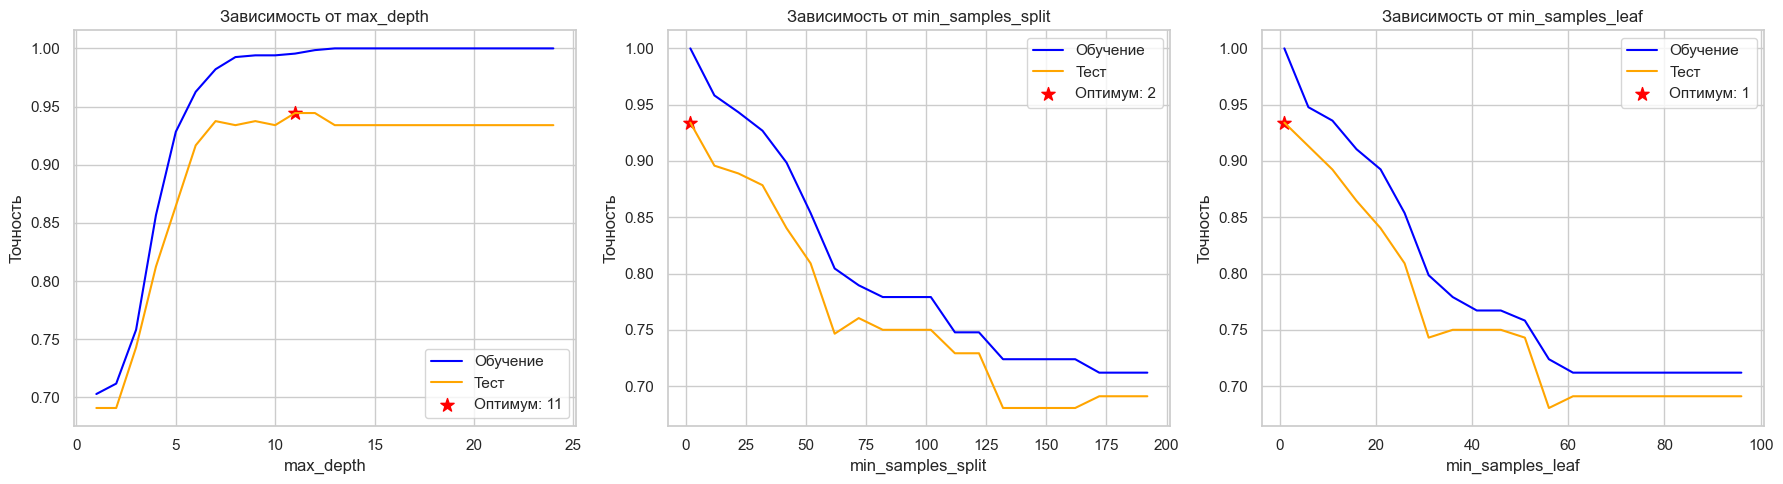

In [60]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

path = 'datasets/tic-tac-toe/tic-tac-toe.data'
df = pd.read_csv(path, header=None)
X = pd.get_dummies(df.iloc[:, :-1])
y = LabelEncoder().fit_transform(df.iloc[:, -1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

search_grids = {
    'max_depth': range(1, 25),
    'min_samples_split': range(2, 200, 10),
    'min_samples_leaf': range(1, 100, 5)
}

param_map = {
    'max_depth': 'max_depth',
    'min_samples_split': 'min_samples_split',
    'min_samples_leaf': 'min_samples_leaf'
}

plt.figure(figsize=(18, 5))

for i, (rus_name, range_vals) in enumerate(search_grids.items()):
    train_scores = []
    test_scores = []
    param_key = param_map[rus_name]
    
    for val in range_vals:
        params = {param_key: val, 'random_state': 42}
        
        tree = DecisionTreeClassifier(**params)
        tree.fit(X_train, y_train)
        
        train_scores.append(tree.score(X_train, y_train))
        test_scores.append(tree.score(X_test, y_test))
    
    plt.subplot(1, 3, i + 1)
    plt.plot(range_vals, train_scores, label='Обучение', color='blue')
    plt.plot(range_vals, test_scores, label='Тест', color='orange')
    
    max_acc = max(test_scores)
    best_val = list(range_vals)[test_scores.index(max_acc)]
    
    plt.scatter(best_val, max_acc, c='red', s=100, marker='*', label=f'Оптимум: {best_val}')
    
    plt.xlabel(rus_name)
    plt.ylabel('Точность')
    plt.title(f'Зависимость от {rus_name}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

__2.4. (1 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:** 
OneHotEncoder показал результаты лучше на датасетах tic-tac-toe или mushrooms. Это из-за того, что признаки там не имеют порядка. На датасетах nursery и knowledge OneHotEncoder может создавать слишком разреженные данные, что может усложнить обучение. Это связано с большим количеством уникальных категорий в них. 

Случайность зависит от random_state при кросс-валидации. Влиять можно с помощью еще с помощью гиперпараметров.

## 3. Практическое задание. Градиентный бустинг ~~своими руками~~

Поздравляю! Это финальное упражнение в нашем курсе. Проявите все своё старание, терпение и опыт, чтобы выполнить его.  
Теперь вы многое знаете из машинного обучения и для вас не составит сложности попробовать разные алгоритмы, новые библиотеки и применить их к реальной задаче.

__3.1. (0.5 балла)__

Мы будем использовать данные соревнования [Home Credit Default Risk](https://www.kaggle.com/c/home-credit-default-risk/data). (Данные уже загружены в папку `datasets/HomeCredit`) 

* Загрузите таблицу **application_train.csv**;
* Запишите в Y столбец с целевой переменной;
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой.

In [15]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_full = pd.read_csv('datasets/HomeCredit/application_train.csv')
initial_cols_count = df_full.shape[1]

Y = df_full['TARGET']

cols_to_drop = ['SK_ID_CURR', 'TARGET']
df = df_full.drop(cols_to_drop, axis=1)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
df_num = df[num_cols].fillna(df[num_cols].median())

X_train, X_test, y_train, y_test = train_test_split(df_num, Y, test_size=0.3, random_state=0)

print(f"Удалено столбцов: {initial_cols_count - df_num.shape[1]}")
print(f"Признаков в работе: {df_num.shape[1]}")
print(f"Обучающая выборка: {X_train.shape[0]}")
print(f"Тестовая выборка: {X_test.shape[0]}")
print(f"Дисбаланс классов: {y_train.value_counts(normalize=True).values}")

Удалено столбцов: 18
Признаков в работе: 104
Обучающая выборка: 215257
Тестовая выборка: 92254
Дисбаланс классов: [0.91877151 0.08122849]


__3.2. (1.5 балла)__

Также мы будем использовать две реализации градиентного бустинга: [LightGBM](https://lightgbm.readthedocs.io/en/stable/Python-API.html) и [Catboost](https://catboost.ai/en/docs/), которые вам необходимо самостоятельно изучить и установить, используя команды:  
`!pip install lightgb`  
`!pip install catboost`  
Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [9]:
!pip3 install lightgbm
!pip install catboost

In [22]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import time
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

lgbm_base = LGBMClassifier(random_state=0, verbose=-1)
start = time.time()
lgbm_base.fit(X_train, y_train)
time_lgbm = time.time() - start
score_lgbm = average_precision_score(y_test, lgbm_base.predict_proba(X_test)[:, 1])

cb_base = CatBoostClassifier(random_state=0, verbose=False)
start = time.time()
cb_base.fit(X_train, y_train)
time_cb = time.time() - start
score_cb = average_precision_score(y_test, cb_base.predict_proba(X_test)[:, 1])

print(f"LightGBM PR-AUC: {score_lgbm:.4f}, Время: {time_lgbm:.2f} сек")
print(f"CatBoost PR-AUC: {score_cb:.4f}, Время: {time_cb:.2f} сек")

if time_lgbm < time_cb:
    print(f"Результат: LightGBM быстрее, чем CatBoost в {time_cb/time_lgbm:.1f} раз")
else:
    print(f"Результат: CatBoost быстрее, чем LightGBM в {time_lgbm/time_cb:.1f} раз")

LightGBM PR-AUC: 0.2292, Время: 1.59 сек
CatBoost PR-AUC: 0.2337, Время: 24.46 сек
Результат: LightGBM быстрее, чем CatBoost в 15.4 раз


__3.3. (2 балла)__

Подберите с CV=3 оптимальные параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения;
* оптимизируемый функционал.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма.

In [27]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import GridSearchCV

lgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'min_child_samples': [20, 30]
}

lgb_grid_search = GridSearchCV(
    LGBMClassifier(objective='binary', metric='binary_logloss', verbose=-1, random_state=15),
    lgb_param_grid, cv=3, scoring='average_precision', n_jobs=-1
)
lgb_grid_search.fit(X_train, y_train)

cb_param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6],
    'learning_rate': [0.05, 0.1]
}

cb_grid_search = GridSearchCV(
    CatBoostClassifier(verbose=False, random_state=0),
    cb_param_grid, cv=3, scoring='average_precision'
)
cb_grid_search.fit(X_train, y_train)

print(f"Лучшие параметры LightGBM: {lgb_grid_search.best_params_}")
print(f"Лучшие параметры CatBoost: {cb_grid_search.best_params_}")

Лучшие параметры LightGBM: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_samples': 20, 'n_estimators': 200}
Лучшие параметры CatBoost: {'depth': 6, 'iterations': 200, 'learning_rate': 0.1}


__3.4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

На получившихся датасетах подберите параметры у каждого из алгоритмов. Как меняется время, необходимое для обучения модели в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [44]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import pandas as pd
import numpy as np
import time
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

X[num_cols] = X[num_cols].fillna(X[num_cols].median())
X[cat_cols] = X[cat_cols].fillna('NA')

def clean_names(df):
    df.columns = [re.sub(r'[^\w\s]', '_', str(c)) for c in df.columns]
    return df

def smooth_encode(train_x, train_y, test_x, cols):
    train_res, test_res = train_x.copy(), test_x.copy()
    global_mean = train_y.mean()
    alpha = 10
    for col in cols:
        stats = train_y.groupby(train_x[col]).agg(['count', 'mean'])
        smooth = (stats['count'] * stats['mean'] + alpha * global_mean) / (stats['count'] + alpha)
        train_res[col] = train_res[col].map(smooth)
        test_res[col] = test_res[col].map(smooth).fillna(global_mean)
    return train_res, test_res

results = []

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)


configs = [
    ('LightGBM', 'OHE'), ('CatBoost', 'OHE'),
    ('LightGBM', 'со сглаживанием'), ('CatBoost', 'со сглаживанием'),
    ('LightGBM', 'встроенный'), ('CatBoost', 'встроенный')
]

for model_name, enc_name in configs:
    print(f"Запуск: {model_name} {enc_name}...")
    
    curr_train, curr_test = X_train_raw.copy(), X_test_raw.copy()
    
    if enc_name == 'OHE':
        curr_train = pd.get_dummies(curr_train)
        curr_test = pd.get_dummies(curr_test).reindex(columns=curr_train.columns, fill_value=0)
        curr_train, curr_test = clean_names(curr_train), clean_names(curr_test)
    elif enc_name == 'со сглаживанием':
        curr_train, curr_test = smooth_encode(curr_train, y_train, curr_test, cat_cols)
        curr_train, curr_test = clean_names(curr_train), clean_names(curr_test)
    elif enc_name == 'встроенный':
        if model_name == 'LightGBM':
            for c in cat_cols:
                curr_train[c] = curr_train[c].astype('category')
                curr_test[c] = curr_test[c].astype('category')
    
    if model_name == 'LightGBM':
        model = LGBMClassifier(n_estimators=200, learning_rate=0.1, random_state=0, verbose=-1)
    else:
        model = CatBoostClassifier(iterations=200, learning_rate=0.1, random_state=0, verbose=0, 
                                   cat_features=cat_cols if enc_name == 'встроенный' else None)
    
    start_t = time.time()
    model.fit(curr_train, y_train)
    elapsed = time.time() - start_t
    
    preds = model.predict_proba(curr_test)[:, 1]
    score = average_precision_score(y_test, preds)
    
    results.append({'Модель': model_name, 'Кодирование': enc_name, 'PR-AUC': round(score, 4), 'Время (сек)': round(elapsed, 2)})

res_df = pd.DataFrame(results)
print(res_df.to_string(index=False))

Запуск: LightGBM OHE...
Запуск: CatBoost OHE...
Запуск: LightGBM со сглаживанием...
Запуск: CatBoost со сглаживанием...
Запуск: LightGBM встроенный...
Запуск: CatBoost встроенный...
  Модель     Кодирование  PR-AUC  Время (сек)
LightGBM             OHE  0.1885         0.69
CatBoost             OHE  0.2052         1.99
LightGBM со сглаживанием  0.1855         0.62
CatBoost со сглаживанием  0.2041         1.96
LightGBM      встроенный  0.1845         0.63
CatBoost      встроенный  0.2088        10.40


__3.5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество.

In [45]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import time

df = pd.read_csv('datasets/HomeCredit/application_train.csv').sample(n=50000, random_state=0)
Y = df['TARGET']
X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
X[cat_cols] = X[cat_cols].fillna('NA')
X_lgbm = X.copy()
for col in cat_cols:
    X_lgbm[col] = X_lgbm[col].astype('category')

X_tr_l, X_te_l, y_train, y_test = train_test_split(X_lgbm, Y, test_size=0.3, random_state=0)
X_tr_c, X_te_c, _, _ = train_test_split(X, Y, test_size=0.3, random_state=0)


lgbm_best = LGBMClassifier(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=7, 
    random_state=0, 
    verbose=-1
)
start = time.time()
lgbm_best.fit(X_tr_l, y_train)
preds_lgbm = lgbm_best.predict_proba(X_te_l)[:, 1]
print(f"LightGBM готов. PR-AUC: {average_precision_score(y_test, preds_lgbm):.4f}")

cat_best = CatBoostClassifier(
    iterations=200, 
    learning_rate=0.05, 
    depth=6, 
    random_state=0, 
    verbose=0, 
    cat_features=cat_cols
)
cat_best.fit(X_tr_c, y_train)
preds_cat = cat_best.predict_proba(X_te_c)[:, 1]
print(f"CatBoost готов. PR-AUC: {average_precision_score(y_test, preds_cat):.4f}")

blended_preds = (preds_lgbm + preds_cat) / 2
score_blended = average_precision_score(y_test, blended_preds)

print("\n--- Результат блендинга ---")
print(f"Итоговый PR-AUC (LGBM + CatBoost): {score_blended:.4f}")

best_single = max(average_precision_score(y_test, preds_lgbm), average_precision_score(y_test, preds_cat))
print(f"Прирост относительно лучшей одиночной модели: {score_blended - best_single:.5f}")

--- Обучение моделей для блендинга ---
LightGBM готов. PR-AUC: 0.1977
CatBoost готов. PR-AUC: 0.2088

--- Результат блендинга ---
Итоговый PR-AUC (LGBM + CatBoost): 0.2075
Прирост относительно лучшей одиночной модели: -0.00131


__3.6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог на важность, с которого начинается хвост неважных признаков) и обучите ту же модель на получившихся данных. Сильно ли упало качество при удалении признаков, которые модель считает неважными?

--- Визуализация важности признаков ---


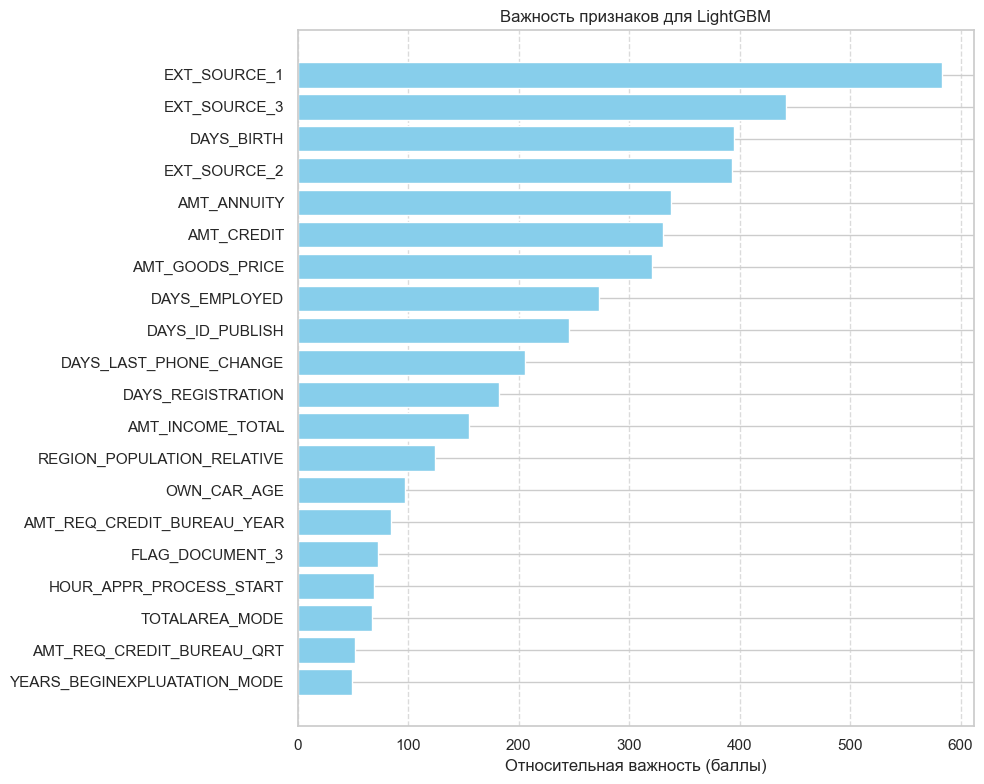

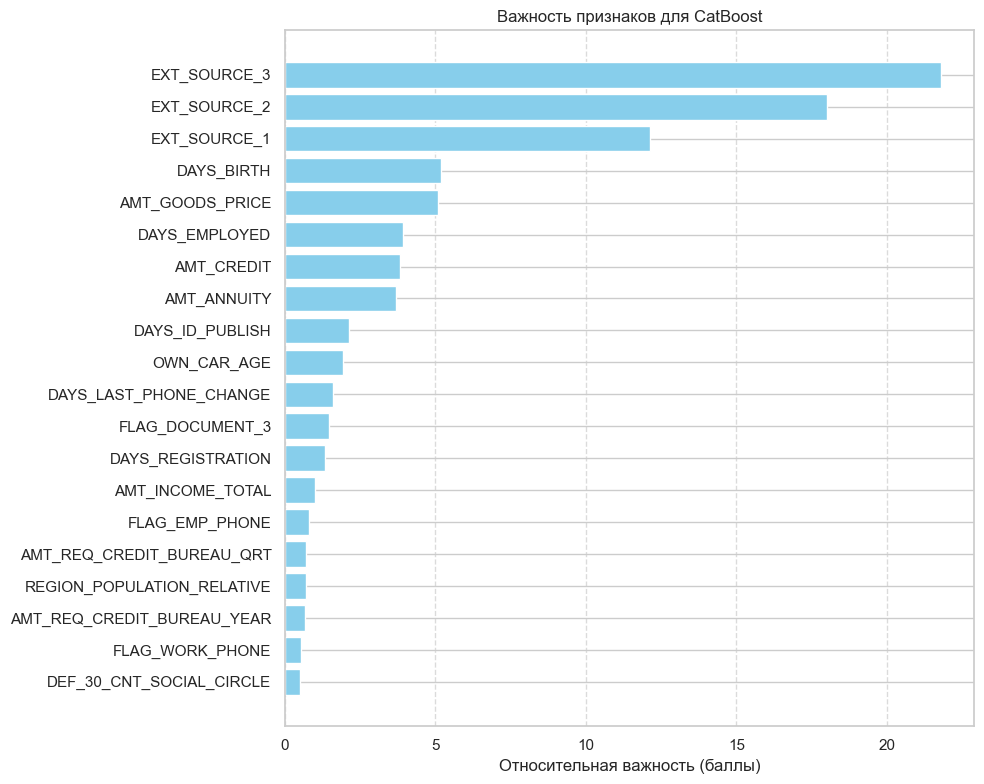

Порог важности: 57.69
Оставлено признаков: 18 из 104
PR-AUC на всех признаках: 0.2323
PR-AUC на отобранных признаках: 0.2290
Падение качества: 0.0033
Время обучения на сокращенных данных: 0.93 сек
Вывод: Качество упало незначительно, модель стала легче и быстрее.


In [36]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
def plot_feature_importance(model, feature_names, model_name):
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(10, 8))
    plt.title(f"Важность признаков для {model_name}")
    plt.barh(range(len(indices[-20:])), importances[indices[-20:]], color='skyblue', align='center')
    plt.yticks(range(len(indices[-20:])), [feature_names[i] for i in indices[-20:]])
    plt.xlabel('Относительная важность (баллы)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

print("--- Визуализация важности признаков ---")
plot_feature_importance(lgb_grid_search.best_estimator_, X_train.columns, "LightGBM")
plot_feature_importance(cb_grid_search.best_estimator_, X_train.columns, "CatBoost")


lgbm_importances = lgb_grid_search.best_estimator_.feature_importances_
threshold = np.mean(lgbm_importances)

important_cols = X_train.columns[lgbm_importances > threshold]

print(f"Порог важности: {threshold:.2f}")
print(f"Оставлено признаков: {len(important_cols)} из {len(X_train.columns)}")


X_train_slim = X_train[important_cols]
X_test_slim = X_test[important_cols]


lgbm_final = LGBMClassifier(**lgb_grid_search.best_params_, verbose=-1, random_state=0)

start_slim = time.time()
lgbm_final.fit(X_train_slim, y_train)
time_slim = time.time() - start_slim


preds_slim = lgbm_final.predict_proba(X_test_slim)[:, 1]
score_slim = average_precision_score(y_test, preds_slim)


old_score = average_precision_score(y_test, lgb_grid_search.best_estimator_.predict_proba(X_test)[:, 1])

print(f"PR-AUC на всех признаках: {old_score:.4f}")
print(f"PR-AUC на отобранных признаках: {score_slim:.4f}")
print(f"Падение качества: {old_score - score_slim:.4f}")
print(f"Время обучения на сокращенных данных: {time_slim:.2f} сек")

if (old_score - score_slim) < 0.01:
    print("Вывод: Качество упало незначительно, модель стала легче и быстрее.")
else:
    print("Вывод: Удаление признаков заметно ухудшило модель, порог слишком строгий.")